In [ ]:
!pip install geovoronoi

In [ ]:
!pip install contextily

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import requests
import os
import contextily as cx
from io import BytesIO
from PIL import Image
from shapely.geometry import Point
from geovoronoi import voronoi_regions_from_coords, points_to_coords
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

In [ ]:
# 1. Team Data: Coordinates, Logo URLs, and Primary Colors
teams = {
    "Toulouse": {"coords": (43.621, 1.415), "color": "#E30613", "img": "logos/Toulouse.png"},
    "Toulon": {"coords": (43.125, 5.934), "color": "#000000", "img": "logos/Toulon.png"},
    "La Rochelle": {"coords": (46.158, -1.171), "color": "#FFD700", "img": "logos/Rochelais.png"},
    "Bordeaux": {"coords": (44.829, -0.598), "color": "#7B1E3B", "img": "logos/Bordeaux.png"},
    # Added a tiny longitude offset (+/- 0.05) to separate the Paris logos
    "Racing 92": {"coords": (48.895, 2.229), "color": "#87CEEB", "img": "logos/Racing.png"},
    "Stade Français": {"coords": (48.844, 2.252), "color": "#F19EC2", "img": "logos/Stade_Francais.png"},
    "Clermont": {"coords": (45.791, 3.106), "color": "#FFF200", "img": "logos/Clermont.png"},
    "Lyon": {"coords": (45.724, 4.832), "color": "#ED1C24", "img": "logos/Lyon.png"},
    "Castres": {"coords": (43.601, 2.249), "color": "#004B94", "img": "logos/Castres.png"},
    "Montpellier": {"coords": (43.590, 3.861), "color": "#003366", "img": "logos/Montpellier.png"},
    "Bayonne": {"coords": (43.484, -1.486), "color": "#99D5F0", "img": "logos/Bayonne.png"},
    "Pau": {"coords": (43.303, -0.322), "color": "#007A33", "img": "logos/Pau.png"},
    "Perpignan": {"coords": (42.711, 2.894), "color": "#FFD700", "img": "logos/Perpignan.png"},
    "Montauban": {"coords": (44.017, 1.355), "color": "#000000", "img": "logos/Montauban.png"}
    # Brittany Region (Northwest Coast)
    # "Vannes": {"coords": (47.662, -2.766), "color": "#002B5C", "img": "vannes.png"}
}

In [ ]:
# 2. Setup Geography
# Load world and filter for France
# url = "https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip"
# world = gpd.read_file(url)
# # Filter for France and clip to mainland coordinates to exclude overseas territories
# france = world[world.ADMIN == 'France'].to_crs(epsg=3857)
# france = france.clip_by_rect(-5.5, 41.0, 10.0, 51.5)
# Use the high-resolution 10m admin-0 dataset for better accuracy
url_high_res = "https://naciscdn.org/naturalearth/10m/cultural/ne_10m_admin_0_countries.zip"
world_hr = gpd.read_file(url_high_res)

# Filter for Mainland France specifically
france_hr = world_hr[world_hr.ADMIN == 'France'].to_crs(epsg=3857)

# Clip to exclude overseas territories (same coordinates as before but higher detail)
france = france_hr.clip_by_rect(-600000, 5000000, 1200000, 6650000)
boundary_shape = france.geometry.union_all()

# Create GeoDataFrame for the points
geometry = [Point(v['coords'][1], v['coords'][0]) for v in teams.values()]
gdf = gpd.GeoDataFrame(geometry=geometry, index=list(teams.keys()), crs="EPSG:4326").to_crs(france.crs)
coords = points_to_coords(gdf.geometry)

# 3. Generate Voronoi Regions
region_polys, region_pts = voronoi_regions_from_coords(coords, boundary_shape)

ERROR:geovoronoi:not enough input points (1) for Voronoi generation; original error message: QH6214 qhull input error: not enough points(1) to construct initial simplex (need 4)

While executing:  | qhull v Qc Qz Qbb
Options selected for Qhull 2020.2.r 2020/08/31:
  run-id 1521369208  voronoi  Qcoplanar-keep  Qz-infinity-point  Qbbound-last
  _pre-merge  _zero-centrum  Qinterior-keep  _maxoutside  0



In [ ]:
# 1. Setup France Boundary (High Res)
url = "https://naciscdn.org/naturalearth/10m/cultural/ne_10m_admin_0_countries.zip"
world = gpd.read_file(url)
france = world[world.ADMIN == 'France'].to_crs(epsg=3857)
france = france.clip_by_rect(-600000, 5000000, 1200000, 6650000)
boundary_shape = france.geometry.union_all()

# 2. Setup Team Points
# Create the GeoDataFrame in Lat/Lon (4326) FIRST
geometry = [Point(v['coords'][1], v['coords'][0]) for v in teams.values()]
gdf = gpd.GeoDataFrame(geometry=geometry, index=list(teams.keys()), crs="EPSG:4326")

# NOW project the points to match the France map (3857)
gdf = gdf.to_crs(france.crs)

# Extract coordinates for Voronoi calculation
coords = points_to_coords(gdf.geometry)

In [ ]:
from shapely.ops import nearest_points

# 1. Create the initial GeoDataFrame
geometry = [Point(v['coords'][1], v['coords'][0]) for v in teams.values()]
gdf = gpd.GeoDataFrame(geometry=geometry, index=list(teams.keys()), crs="EPSG:4326")
gdf = gdf.to_crs(france.crs)

# 2. Ensure all points are INSIDE the boundary_shape
# If a point is in the sea (like Toulon might be), move it to the nearest land
for idx, row in gdf.iterrows():
    if not row.geometry.within(boundary_shape):
        print(f"Relocating {idx} to the nearest land point...")
        # Find the point on the boundary closest to the original point
        p1, p2 = nearest_points(boundary_shape, row.geometry)
        # We update the GDF with the point on land (p1)
        gdf.at[idx, 'geometry'] = p1

# 3. Extract coordinates now that they are guaranteed to be inside
coords = points_to_coords(gdf.geometry)

Relocating Toulon to the nearest land point...


In [ ]:
# Calculate Voronoi regions using the high-res boundary
# We use the index from gdf to keep team names aligned with regions
region_polys, region_pts = voronoi_regions_from_coords(coords, boundary_shape)

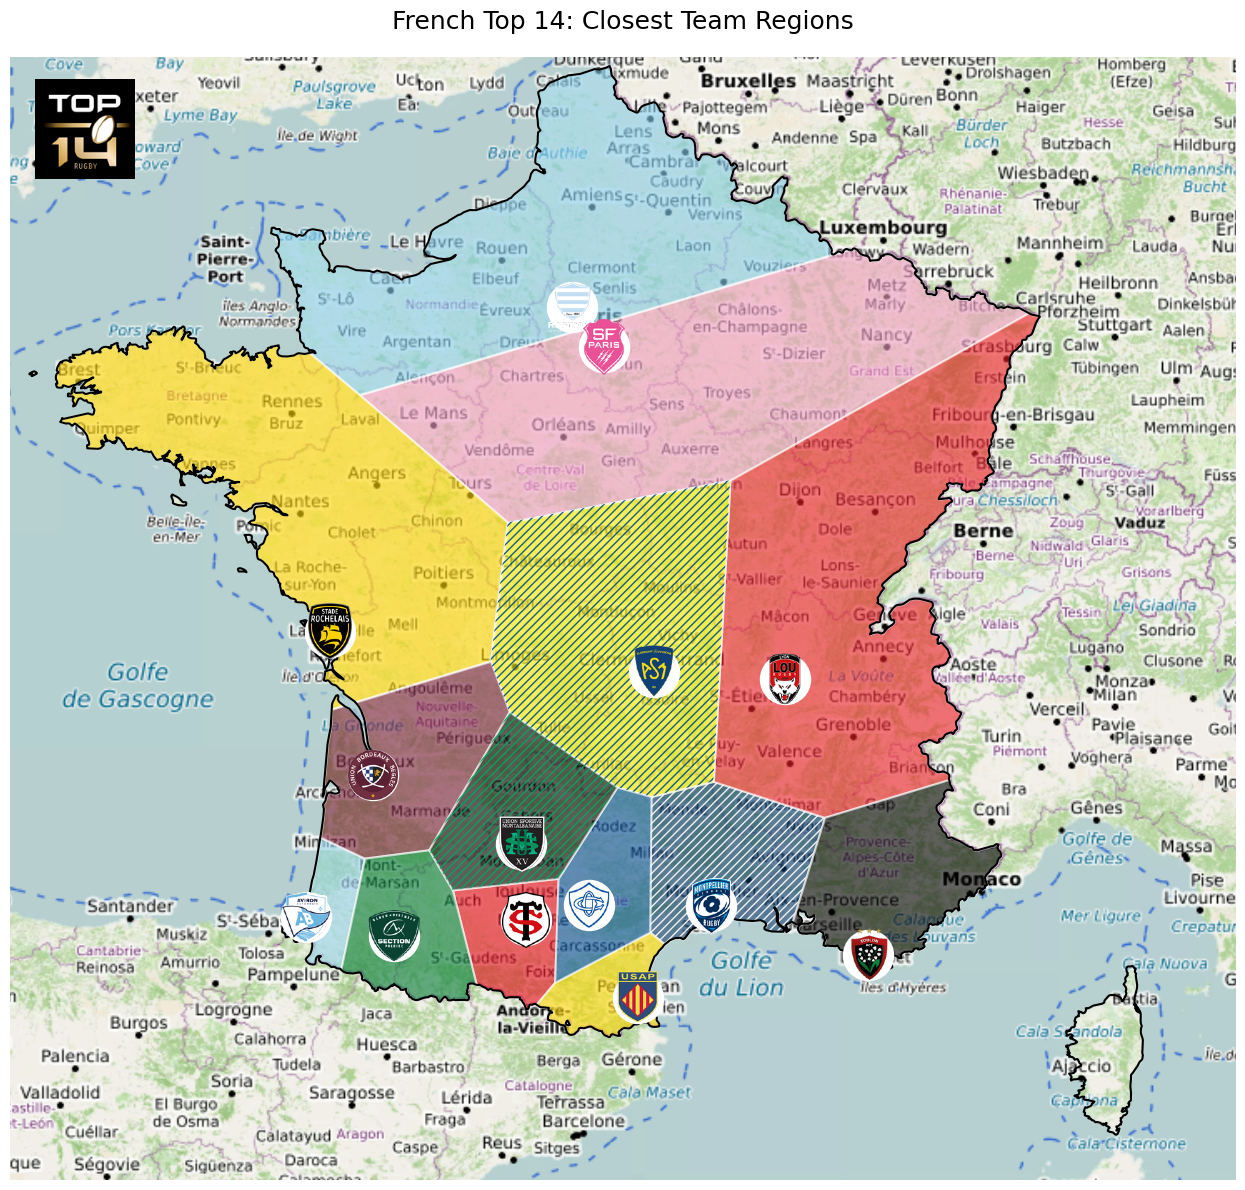

In [ ]:
# 4. Plotting
fig, ax = plt.subplots(figsize=(14, 12))
france.plot(ax=ax, color='none', edgecolor='black', linewidth=1.5, zorder=3)

# 1. Plot the regions as before
# Updated plotting loop for colored hatching
for region_id, poly in region_polys.items():
    team_idx = region_pts[region_id][0]
    team_name = list(teams.keys())[team_idx]
    team_color = teams[team_name]['color']

    # 1. Plot the base solid color for every region
    gpd.GeoSeries(poly).plot(
        ax=ax,
        facecolor=team_color,
        alpha=0.6,
        edgecolor='white',
        linewidth=1.5,
        zorder=1
    )

    # 2. Add colored hatching for specific teams
    hatch_color = None
    if team_name == "Clermont":
        hatch_color = "#004B94"  # Clermont Blue stripes
    elif team_name == "Montpellier":
        hatch_color = "white"    # Montpellier White stripes
    elif team_name == "Montauban":
        hatch_color = "#00A95C" # Green stripes

    if hatch_color:
        # We plot the same polygon again but with a transparent face
        # The 'edgecolor' here defines the stripe color
        gpd.GeoSeries(poly).plot(
            ax=ax,
            facecolor="none",
            edgecolor=hatch_color,
            hatch="////",
            linewidth=0, # No border for the hatch layer
            alpha=0.9,
            zorder=2
        )

# 2. Add detailed "Google Maps" style background (Cities/Roads)
import contextily as cx
# cx.add_basemap(ax, source=cx.providers.CartoDB.Positron, alpha=0.8
# Use the OpenStreetMap France tiles for French labels
cx.add_basemap(ax, source='https://{s}.tile.openstreetmap.fr/osmfr/{z}/{x}/{y}.png')

# Standardize height for all logos
base_height = 80

for name, data in teams.items():
    # 1. Use ORIGINAL coordinates for finding the center
    team_row = gdf.loc[name]
    x, y = team_row.geometry.x, team_row.geometry.y

    # 2. Apply "Display Only" offsets to the Paris teams
    # These coordinates are in meters (EPSG:3857), so 15000 is about 15km
    if name == "Racing 92":
        x -= 22000  # Nudge left
        y += 25000  # Nudge up
    elif name == "Stade Français":
        x += 22000  # Nudge right
        y -= 25000  # Nudge down
    elif name == "Montauban":
        y += 25000  # Move up 25km
    elif name == "Toulouse":
        y -= 25000  # Move down 25km


    file_path = data.get('img')
    if file_path and os.path.exists(file_path):
        try:
            # (Logo loading and halo code stays the same)
            img = Image.open(file_path).convert("RGBA")
            h_percent = (base_height / float(img.size[1]))
            w_size = int((float(img.size[0]) * h_percent))
            img = img.resize((w_size, base_height), Image.Resampling.LANCZOS)

            # Plot the white halo and logo at the NUDGED coordinates
            ax.plot(x, y, marker='o', color='white', markersize=36, zorder=4)

            imagebox = OffsetImage(img, zoom=0.5)
            ab = AnnotationBbox(imagebox, (x, y), frameon=False, zorder=5)
            ax.add_artist(ab)

        except Exception as e:
            print(f"Error for {name}: {e}")

# 3. Load the Top 14 logo
top14_logo_path = "logos/top14.png" # Make sure this matches your filename
if os.path.exists(top14_logo_path):
    img_top14 = Image.open(top14_logo_path).convert("RGBA")

    # 2. Scale it (e.g., set height to 120px for a prominent look)
    h_top14 = 120
    w_top14 = int((float(img_top14.size[0]) * (h_top14 / float(img_top14.size[1]))))
    img_top14 = img_top14.resize((w_top14, h_top14), Image.Resampling.LANCZOS)

    # 3. Place in the top-left corner
    # xy=(0.02, 0.98) puts it 2% away from the top and left edges
    imagebox_top14 = OffsetImage(img_top14, zoom=0.6)
    ab_top14 = AnnotationBbox(
        imagebox_top14,
        xy=(0.02, 0.98),
        xycoords='axes fraction',
        box_alignment=(0, 1), # Align top-left of the logo to the coordinate
        frameon=False,
        zorder=10 # Ensure it is on top of everything
    )
    ax.add_artist(ab_top14)
else:
    print("Top 14 logo file not found!")

# 4. CRITICAL: Force the zoom onto Mainland France
ax.set_xlim(-600000, 1200000)
ax.set_ylim(5000000, 6650000)
# Add this line right after the Voronoi loop to add the background map
# cx.add_basemap(ax, source=cx.providers.CartoDB.Positron)
cx.add_basemap(ax, source='https://{s}.tile.openstreetmap.fr/osmfr/{z}/{x}/{y}.png')


plt.title("French Top 14: Closest Team Regions", fontsize=18, pad=20)
ax.set_axis_off()
plt.tight_layout()
plt.show()

In [ ]:
pro_d2_teams_updated = {
    # Coastal / Northwest
    "Vannes": {"coords": (47.662, -2.766), "color": "#002B5C", "img": "logos2/vannes.png"},

    # Southwest / Occitanie
    "Brive": {"coords": (45.147, 1.526), "color": "#000000", "img": "logos2/brive.png"},
    "Biarritz": {"coords": (43.476, -1.551), "color": "#E30613", "img": "logos2/biarritz.png"},
    "Agen": {"coords": (44.197, 0.622), "color": "#002B5C", "img": "logos2/agen.png"},
    "Colomiers": {"coords": (43.611, 1.341), "color": "#004B94", "img": "logos2/colomiers.png"},
    "Mont-de-Marsan": {"coords": (43.892, -0.491), "color": "#FFF200", "img": "logos2/montois.png"},
    "Dax": {"coords": (43.712, -1.051), "color": "#E30613", "img": "logos2/dax.png"},
    "Béziers": {"coords": (43.344, 3.237), "color": "#E30613", "img": "logos2/beziers.png"},
    "Carcassonne": {"coords": (43.210, 2.350), "color": "#FFF200", "img": "logos2/carcassonne.png"}, # NEW: Promoted

    # Auvergne-Rhône-Alpes / East
    "Oyonnax": {"coords": (46.262, 5.656), "color": "#E30613", "img": "logos2/oyonnax.png"},
    "Grenoble": {"coords": (45.178, 5.742), "color": "#004B94", "img": "logos2/grenoble.png"},
    "Aurillac": {"coords": (44.921, 2.441), "color": "#E30613", "img": "logos2/aurillac.png"},
    "Valence Romans": {"coords": (44.931, 4.901), "color": "#000000", "img": "logos2/valence.png"},
    "Provence": {"coords": (43.541, 5.421), "color": "#000000", "img": "logos2/provence.png"},

    # Central / North
    "Nevers": {"coords": (46.993, 3.146), "color": "#FFF200", "img": "logos2/nevers.png"},
    "Soyaux-Angoulême": {"coords": (45.657, 0.171), "color": "#87CEEB", "img": "logos2/angouleme.png"}
}

In [ ]:
# 1. Re-calculate GDF and Voronoi with ALL teams
geometry = [Point(v['coords'][1], v['coords'][0]) for v in pro_d2_teams_updated.values()]
gdf_all = gpd.GeoDataFrame(geometry=geometry, index=list(pro_d2_teams_updated.keys()), crs="EPSG:4326").to_crs(epsg=3857)

# Snap to land check
for idx, row in gdf_all.iterrows():
    if not row.geometry.within(boundary_shape):
        p1, _ = nearest_points(boundary_shape, row.geometry)
        gdf_all.at[idx, 'geometry'] = p1

coords_all = points_to_coords(gdf_all.geometry)
region_polys, region_pts = voronoi_regions_from_coords(coords_all, boundary_shape)



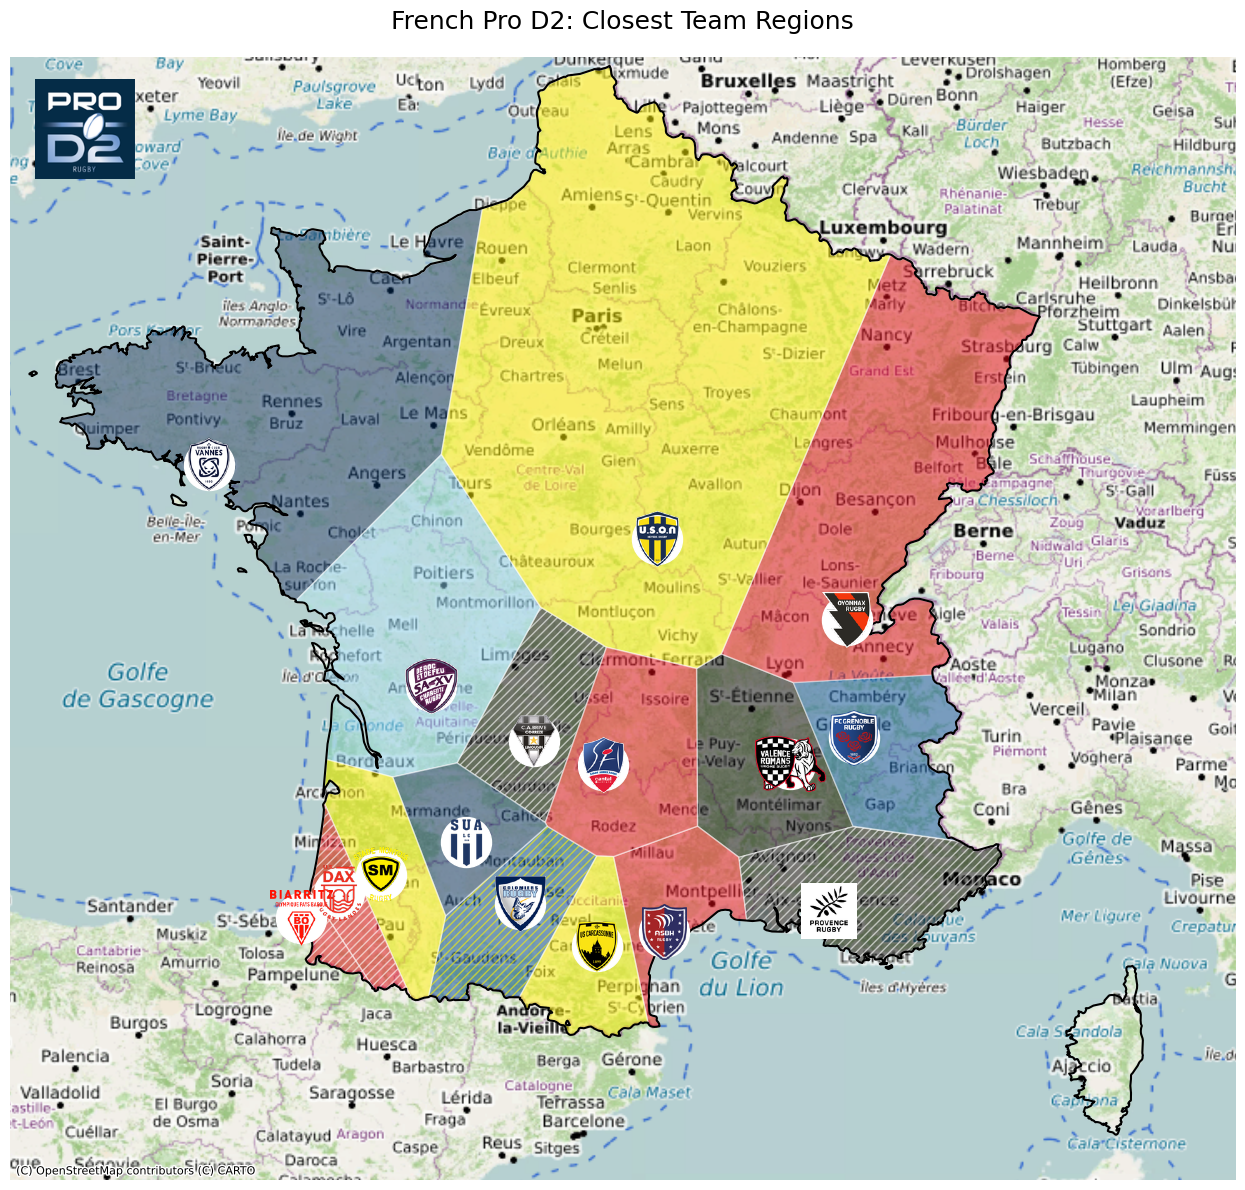

In [ ]:
# 4. Plotting
fig, ax = plt.subplots(figsize=(14, 12))

# Use base_height variable for scaling
base_height = 80

# 1. Plot the base regions
for region_id, poly in region_polys.items():
    team_name = list(pro_d2_teams_updated.keys())[region_pts[region_id][0]]
    team_color = pro_d2_teams_updated[team_name]['color']

    gpd.GeoSeries(poly).plot(ax=ax, facecolor=team_color, alpha=0.5, edgecolor='white', linewidth=1)

    # Hatching Logic
    h_color = None
    if team_name in ["Biarritz", "Dax"]: h_color = "white"
    elif team_name in ["Brive", "Provence"]: h_color = "white"
    elif team_name == "Colomiers": h_color = "#FFF200"

    if h_color:
        gpd.GeoSeries(poly).plot(ax=ax, facecolor="none", edgecolor=h_color, hatch="////", linewidth=0, alpha=0.6)

# 2. Corrected Logo Loop
for name, data in pro_d2_teams_updated.items():
    team_row = gdf_all.loc[name]
    x, y = team_row.geometry.x, team_row.geometry.y

    # Corrected path: data['img'] contains the path to logos2/
    img_path = data['img']

    if os.path.exists(img_path):
        try:
            # FIX: Open the specific image for THIS team
            img = Image.open(img_path).convert("RGBA")

            h_percent = (base_height / float(img.size[1]))
            w_size = int((float(img.size[0]) * h_percent))
            img = img.resize((w_size, base_height), Image.Resampling.LANCZOS)

            ax.plot(x, y, marker='o', color='white', markersize=36, zorder=4)

            imagebox = OffsetImage(img, zoom=0.5)
            ab = AnnotationBbox(imagebox, (x, y), frameon=False, zorder=5)
            ax.add_artist(ab)

        except Exception as e:
            print(f"Error for {name}: {e}")
    else:
        print(f"File not found for {name}: {img_path}")

# 3. Add the boundary and background
france.plot(ax=ax, color='none', edgecolor='black', linewidth=1.5, zorder=3)
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron)

# ... (rest of your Top 14 logo and display code) ...

    # 3. Load the Top 14 logo
top14_logo_path = "logos2/pro-d2.png" # Make sure this matches your filename
if os.path.exists(top14_logo_path):
    img_top14 = Image.open(top14_logo_path).convert("RGBA")

    # 2. Scale it (e.g., set height to 120px for a prominent look)
    h_top14 = 120
    w_top14 = int((float(img_top14.size[0]) * (h_top14 / float(img_top14.size[1]))))
    img_top14 = img_top14.resize((w_top14, h_top14), Image.Resampling.LANCZOS)

    # 3. Place in the top-left corner
    # xy=(0.02, 0.98) puts it 2% away from the top and left edges
    imagebox_top14 = OffsetImage(img_top14, zoom=0.6)
    ab_top14 = AnnotationBbox(
        imagebox_top14,
        xy=(0.02, 0.98),
        xycoords='axes fraction',
        box_alignment=(0, 1), # Align top-left of the logo to the coordinate
        frameon=False,
        zorder=10 # Ensure it is on top of everything
    )
    ax.add_artist(ab_top14)
else:
    print("Top 14 logo file not found!")

# 4. CRITICAL: Force the zoom onto Mainland France
ax.set_xlim(-600000, 1200000)
ax.set_ylim(5000000, 6650000)
# Add this line right after the Voronoi loop to add the background map
# cx.add_basemap(ax, source=cx.providers.CartoDB.Positron)
# Use the OpenStreetMap France tiles for French labels
cx.add_basemap(ax, source='https://{s}.tile.openstreetmap.fr/osmfr/{z}/{x}/{y}.png')

plt.title("French Pro D2: Closest Team Regions", fontsize=18, pad=20)
ax.set_axis_off()
plt.tight_layout()
plt.show()